# Find good settings for alignment using `scikit-image` approach (***recommended***)

In [1]:
from skimage.io import imread, imshow, imsave
from skimage import transform
import matplotlib.pyplot as plt
import numpy as np
import PIL
from PIL import ImageEnhance

## Set paths to `jpg`s for RGB image and extracted hyperspectral channel for grid standard

We are opening the version of the RGB image with the `pre-scikit` suffix. This was produced in notebook `1_Find_pre_aligned_rgb_grid_borders.ipynb` and has been preprocessed to have an orientation matching the hyperspectral image.

In [2]:
rgb_path = '../example_12-spot_grid_pre-scikit.jpg'
hyp_path = '2-OUT_hypercube_layer.jpg'

## Define x and y coordinates for corners of grid to be aligned

Below are grid corners for the RGB and hyperspectral images. 

Similar to how we found grid borders, we will now find grid edges. See the below screenshot for an example of finding the top-left x, y position at **1006, 528**<br><br>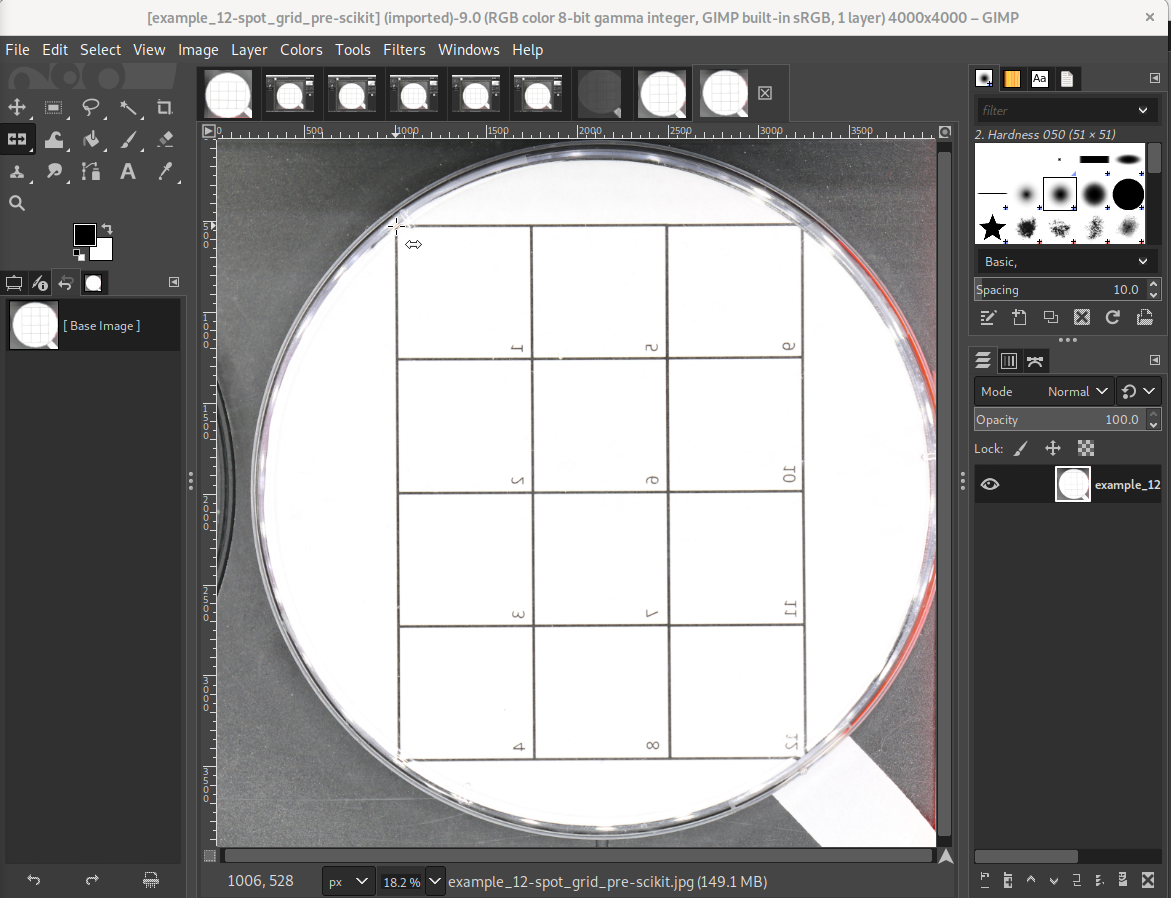. 

In [3]:
#source coordinates
src = np.array([1006, 528, # top-left
                3240, 519, # top-right
                1023, 3465, # bottom-left
                3260, 3456,]).reshape((4, 2)) # bottom-right

Below are grid corners for the hyperspectral data. The screenshot shows an example of using GIMP to find the top-left corner x, y position at **314, 130**.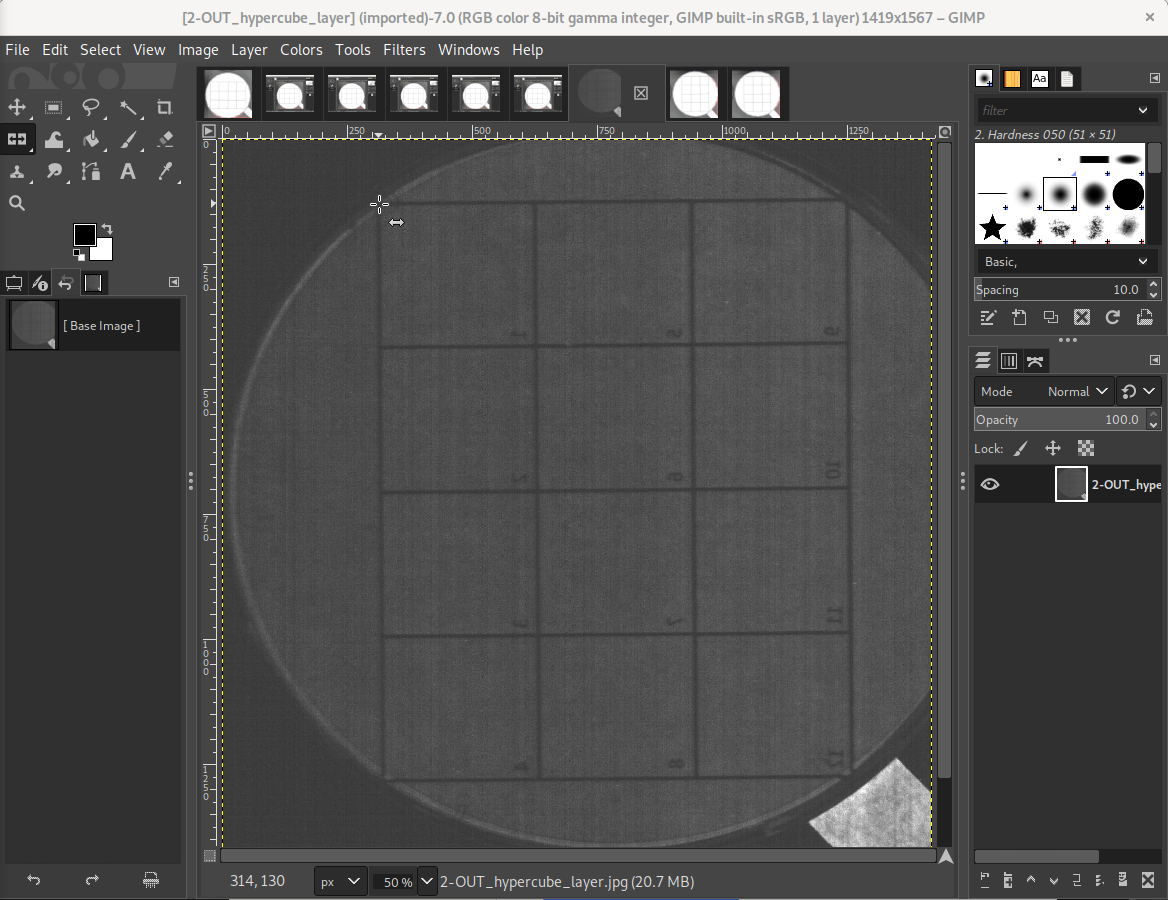

In [4]:
#destination coordinates
dst = np.array([314, 130, # top-left
                1252, 120, # top-right
                324, 1283, # bottom-left
                1258, 1274,]).reshape((4, 2)) #bottom-right

## Import images, compute homography image and inspect alignment

### Load images

In [5]:
rgb = imread(rgb_path)
hyp = imread(hyp_path)

### Compute homography matrix

In [6]:
#using skimage’s transform module where ‘projective’ is our desired parameter
tform = transform.estimate_transform('projective', src, dst)
tf_img = transform.warp(rgb, tform.inverse)

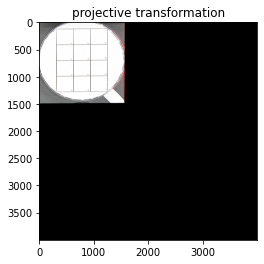

In [7]:
#plotting the transformed image
fig, ax = plt.subplots()
ax.imshow(tf_img)
_ = ax.set_title('projective transformation')

What is the homography matrix?

In [8]:
tform

<ProjectiveTransform(matrix=
    [[ 4.19688848e-01,  1.60001047e-03, -1.08847897e+02],
     [-2.93116345e-03,  3.95313237e-01, -7.56922255e+01],
     [-3.63580433e-07,  1.92252367e-06,  1.00000000e+00]]) at 0x7f359e70be20>

### Check how well alignment worked

In [9]:
imsave('3A-INTERMEDIATE_scikit-rgb-out.png', tf_img)

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


#### Read (aligned) rgb and hyperspec images in with `PIL`

In [10]:
rgb = PIL.Image.open('3A-INTERMEDIATE_scikit-rgb-out.png').convert('RGB')

How does the RGB image look after alignment, but before cropping?

In [11]:
#rgb

In [12]:
hyp = PIL.Image.open(hyp_path).convert('RGB')

How does the hyperspectral channel look?

In [13]:
#hyp

#### Crop RGB to match hyperspectral dimensions

In [14]:
width, height = hyp.size

In [15]:
rgb_cropped = rgb.crop((0, 0, width, height))

In [16]:
#rgb_cropped

#### Invert RGB and color it red

In [17]:
rgb_cropped = PIL.ImageOps.invert(rgb_cropped)

In [18]:
# A 12-value tuple which is a transform matrix for dropping 
# green channel (in this case)
matrix = ( 1, 0, 0, 0,
           0, 0, 0, 0,
           0, 0, 0, 0)

In [19]:
rgb_colored = rgb_cropped.convert("RGB", matrix)

In [20]:
#rgb_colored

#### Invert hyperspectral channel and color it blue

In [21]:
hyp = PIL.ImageOps.invert(hyp)

In [22]:
matrix = ( 0, 0, 0, 0,
           0, 0, 1, 0,
           0, 0, 1, 0)

In [23]:
hyp_colored = hyp.convert("RGB", matrix)
hyp_colored = PIL.ImageEnhance.Contrast(hyp_colored)
hyp_colored = hyp_colored.enhance(1.5)

In [24]:
#hyp_colored

#### View overlaid RGB and hyperspectral layers.

In [25]:
overlay = PIL.Image.blend(rgb_colored, hyp_colored, alpha = 0.3)

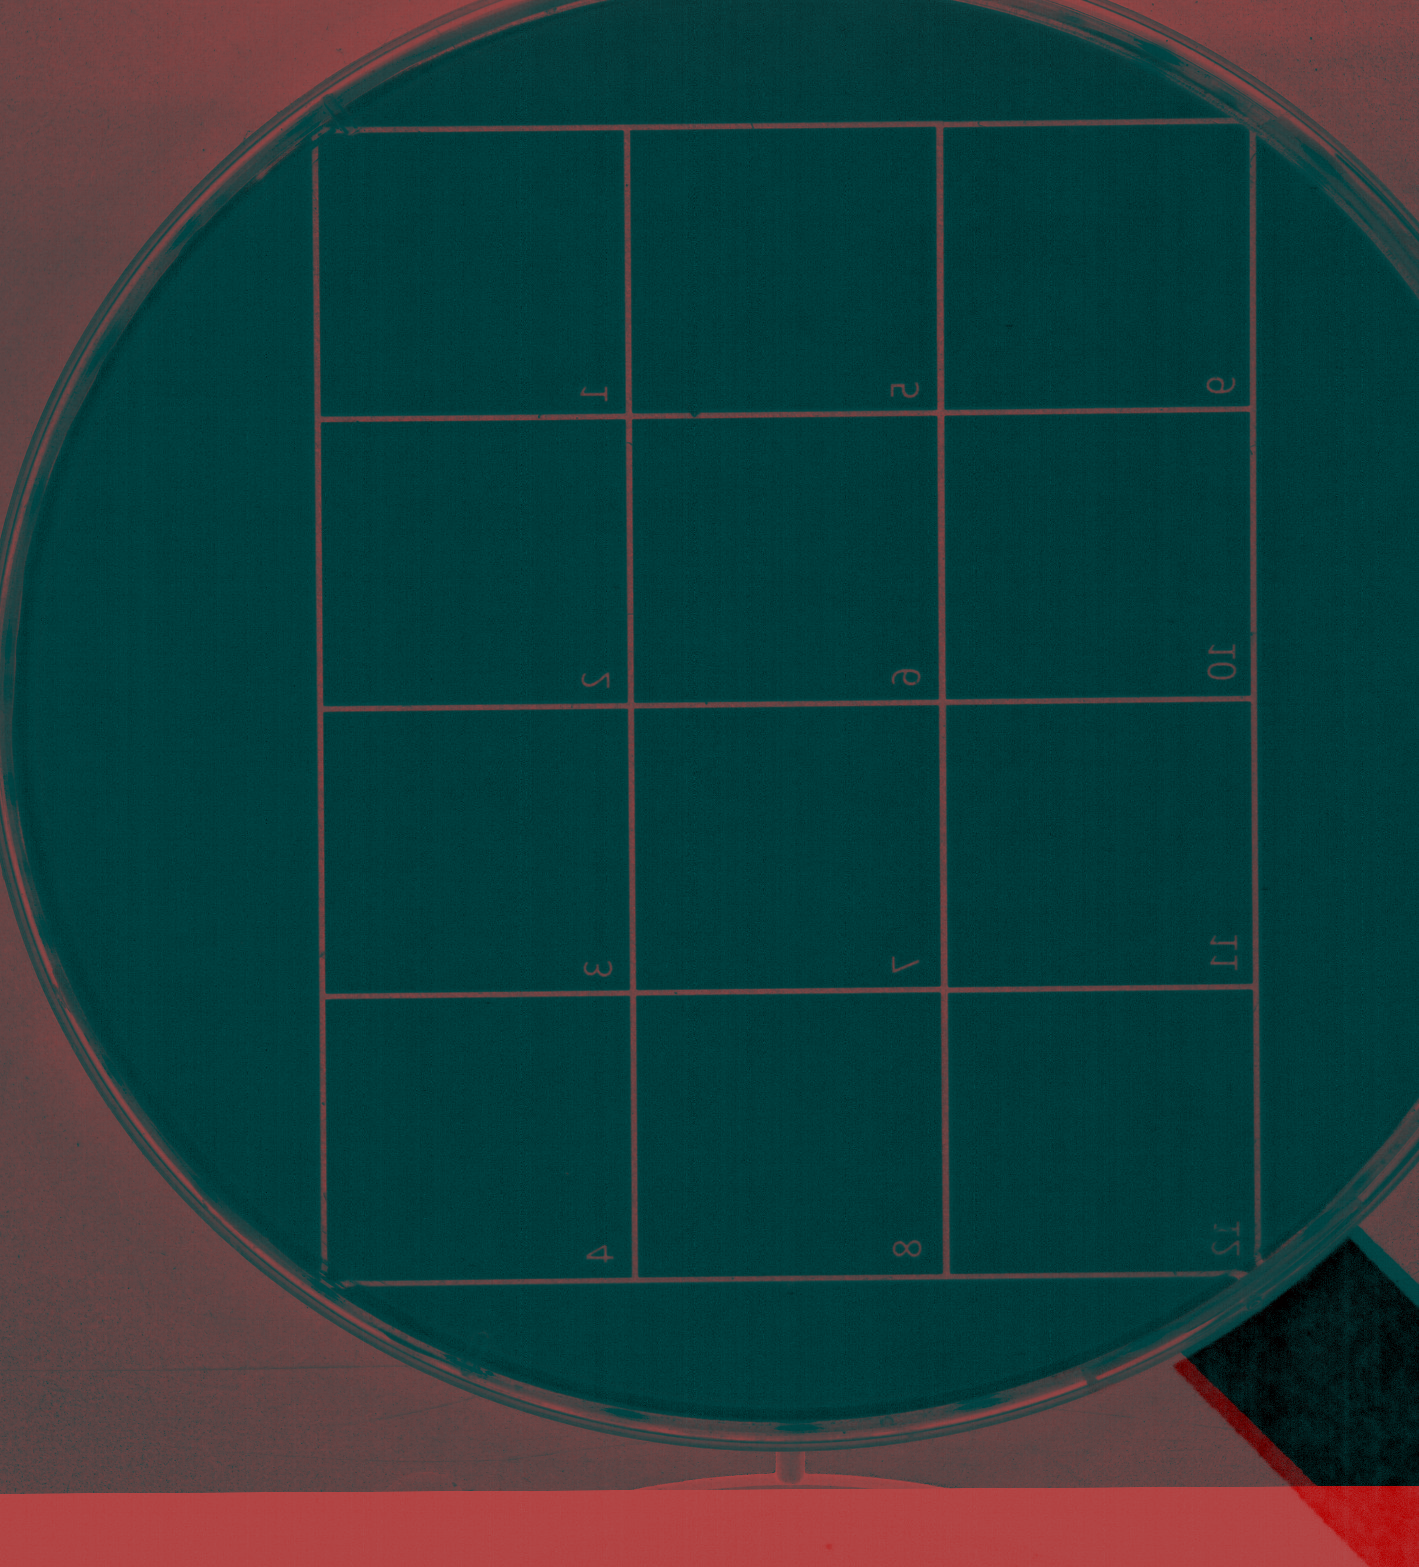

In [26]:
overlay

Note: In the example image, the tape on the tray beneath the plate does not align as well as the plate itself. This is a normal result.

## Save out homography matrix

In [28]:
np.save("3A-OUT_Example_aligned.npy", tform.params)

## Save out aligned and cropped RGB image

In [29]:
rgb_cropped.save("3A-OUT_Example_aligned.jpg")